In [1]:
import sys
sys.path.append('..')

In [2]:
import os
import pickle

import tqdm
import numpy as np
import seaborn as sns
import pandas as pd

from matplotlib import pyplot as plt
from sklearn.svm import SVC

from src import credit_utils as cred

import plot_params

## Influence Heuristic Analysis

In [3]:
influence_data = pd.read_csv("../influence_data.csv")
influence_data.rename(columns={"Unnamed: 0": "idx"}, inplace=True)
influence_data.head()

,idx,influence,score,acc
0,0,385.927793,1.0,0.937595
1,1,241.597630,0.0,0.936073
2,2,166.810019,2.0,0.936073
3,3,125.943244,0.0,0.936073
4,4,412.487517,2.0,0.937595


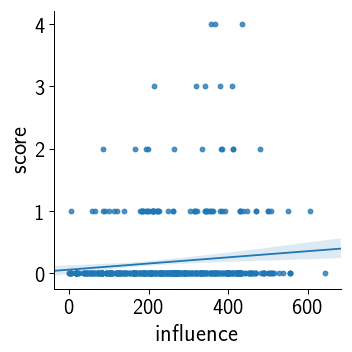

In [4]:
sns.lmplot(data=influence_data, x="influence", y="score")

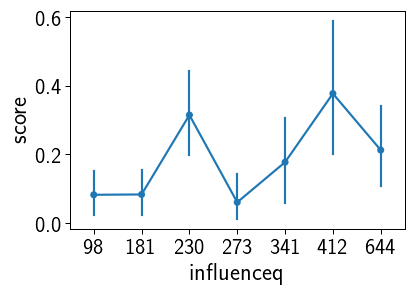

In [5]:
influence_data["influenceq"] = pd.qcut(influence_data.influence, 7).map(lambda t: int(t.right))
sns.pointplot(data=influence_data, x="influenceq", y="score")

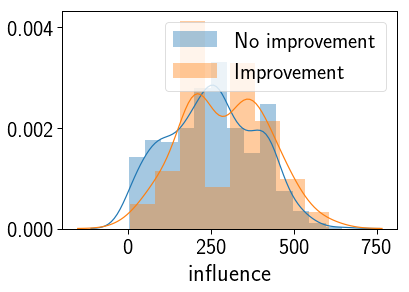

In [6]:
fig, ax = plt.subplots()

sns.distplot(influence_data.query("score == 0.0").influence, ax=ax, label="No improvement")
sns.distplot(influence_data.query("score > 0.0").influence, ax=ax, label="Improvement")
plt.legend()

## Load simulation data

In [7]:
DATA_BASE_PATH = '../out'

In [8]:
SEED = 1

In [9]:
IMAGES_DIR = '../images'
!mkdir -p {IMAGES_DIR}

In [10]:
def get_sim_data(report_name_regex):
    report_filenames = !ls {DATA_BASE_PATH} | grep {report_name_regex}
    print('Number of reports:', len(report_filenames))
    
    report_paths = [os.path.join(DATA_BASE_PATH, name) for name in report_filenames]
    sim_datasets = []
    for report_path in report_paths:
        with open(report_path, 'rb') as f:
            cum_group_datasets = pickle.load(f)
        sim_datasets.append(cum_group_datasets)
    return sim_datasets

In [11]:
noisy_datasets_50 = get_sim_data('group_poisoning_influence_seed_%d_noise_50' % SEED)

Number of reports: 10


In [12]:
noisy_datasets_10 = get_sim_data('group_poisoning_influence_seed_%d_noise_10' % SEED)

Number of reports: 10


In [13]:
base_datasets = get_sim_data('group_poisoning_influence_seed_%d_noise_0_sim_0' % SEED)

Number of reports: 1


## Restore the poisoned models

In [14]:
df, df_X, df_y = cred.load_dataframes('../data/german_credit_data.csv')
datasets = cred.to_numpy_data(df_X, df_y, seed=SEED)
X, y, X_train, y_train, X_test, y_test = (
    datasets.X, datasets.y, datasets.X_train, datasets.y_train, datasets.X_test, datasets.y_test)
clf, params = cred.train_model(X_train, y_train, X_test, y_test)

Shape of X: (1000, 38). Shape of y: (1000,).
Baseline accuracy is: 0.69875
Test score is: 75.50%.


In [15]:
def get_models_by_sim(sim_datasets):
    models_by_sim = []
    for sim in tqdm.tqdm_notebook(sim_datasets):
        sim_models = []
        for dataset in sim:
            X_train_adv, y_train_adv = dataset
            clf_poisoned, _ = cred.train_model(
                X_train_adv, y_train_adv, X_test, y_test, verbose=False)
            sim_models.append(clf_poisoned)
        models_by_sim.append(sim_models)
    return models_by_sim

In [16]:
noisy_models_50 = get_models_by_sim(noisy_datasets_50)
noisy_models_10 = get_models_by_sim(noisy_datasets_10)

In [17]:
base_models = get_models_by_sim(base_datasets)

## Visualize the effects of poisoning

In [18]:
sns.set(font_scale=1.4, style='white')

In [19]:
def score(clf, group):
    return np.mean(clf.predict(group) == 1)

Target group

In [20]:
target_group_sel = (df['Checking account_little'] == 1) & \
                   (df['Saving accounts_little'] == 1) & \
                   (df['Risk_good'] == 1) & \
                   (clf.predict(X) == 0).astype(bool)
                    

target_group = X[target_group_sel]
target_group_y = y[target_group_sel]
print('Size', len(target_group), '/ Acceptance rate:', score(clf, target_group))

Size 43 / Acceptance rate: 0.0


Control group 0: everyone but the target group

In [21]:
control_group_0_mask = [i for i in datasets.train_ind if i not in np.where(target_group_sel)[0]]
control_group_0 = X[control_group_0_mask]
control_group_0_y = y[control_group_0_mask]
print('Size', len(control_group_0), '/ Acceptance rate:', score(clf, control_group_0))

Size 764 / Acceptance rate: 0.8180628272251309


In [23]:
def get_group_scores(model_sets):
    groups = {
        'Target': (target_group, target_group_y),
        'Everyone else': (control_group_0, control_group_0_y),
    }
    group_scores_df = pd.DataFrame(
        columns=['sim', 'poison_size', 'Group', 'score_change'])

    for sim_num, models in enumerate(tqdm.tqdm_notebook(model_sets)):
        clf = models[0]
        for poison_size, clf_adv in enumerate([clf] + models):
            for group_id, (group, group_y) in groups.items():
                init_fp = np.sum((clf.predict(group) == 0) & (group_y == 1)).astype(float)
                adv_fp = np.sum((clf_adv.predict(group) == 0) & (group_y == 1)).astype(float)
                init_fn = np.sum((clf.predict(group) == 1) & (group_y == 0)).astype(float)
                adv_fn = np.sum((clf_adv.predict(group) == 1) & (group_y == 0)).astype(float)
                group_scores_df = group_scores_df.append(
                    {'sim': sim_num,
                     'poison_size': poison_size,
                     'Group': group_id, # Need to capitalize the name for the plot.                     
                     'fp_change': adv_fp - init_fp,
                     'fn_change': adv_fn - init_fn,
                    },
                    ignore_index=True)

    group_scores_df.sim = group_scores_df.sim.astype(int)
    group_scores_df.poison_size = group_scores_df.poison_size.astype(int)
    
    return group_scores_df

In [24]:
noisy_scores_50_df = get_group_scores(noisy_models_50)
noisy_scores_10_df = get_group_scores(noisy_models_10)

In [25]:
base_scores_df = get_group_scores(base_models)

In [26]:
base_scores_df.poison_size = base_scores_df.poison_size - 1
base_scores_df = base_scores_df[base_scores_df.poison_size != -1]

noisy_scores_50_df.poison_size = noisy_scores_50_df.poison_size - 1
noisy_scores_50_df = noisy_scores_50_df[noisy_scores_50_df.poison_size != -1]

noisy_scores_10_df.poison_size = noisy_scores_10_df.poison_size - 1
noisy_scores_10_df = noisy_scores_10_df[noisy_scores_10_df.poison_size != -1]

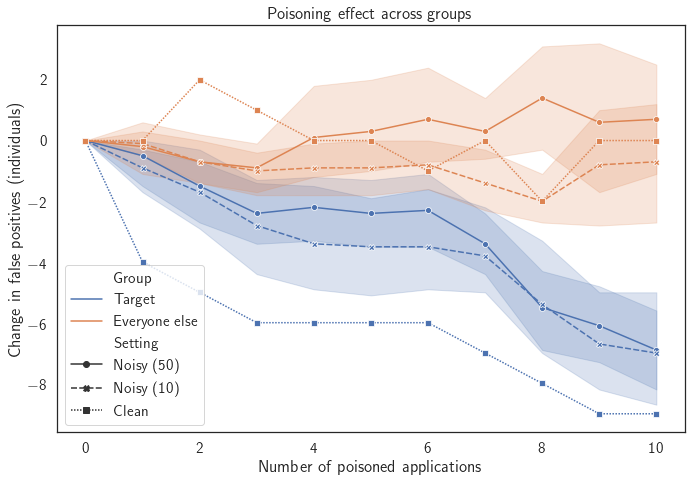

In [27]:
fig, ax = plt.subplots()

noisy_scores_50_df["Setting"] = "Noisy (50)"
noisy_scores_10_df["Setting"] = "Noisy (10)"
base_scores_df["Setting"] = "Clean"

sns.lineplot(data=pd.concat([noisy_scores_50_df, noisy_scores_10_df, base_scores_df]),
             x='poison_size', y='fp_change', hue='Group', style="Setting",
             markers=True,
             ci=99, err_style="band", ax=ax)

# ax.set_ylim(-40, 40)
ax.set_ylabel("Change in false positives (individuals)")
ax.set_xlabel("Number of poisoned applications")
ax.set_title("Poisoning effect across groups")

plt.legend()

fig.set_figwidth(10)
fig.set_figheight(7)
fig.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'poisoning_comparison_fp.pdf'))

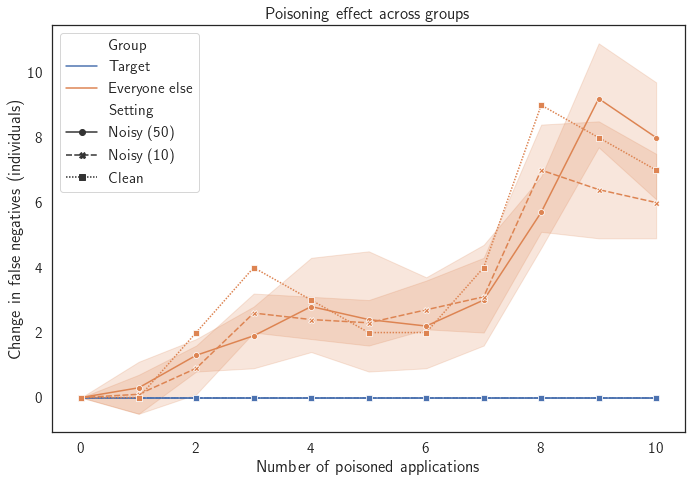

In [28]:
fig, ax = plt.subplots()

noisy_scores_50_df["Setting"] = "Noisy (50)"
noisy_scores_10_df["Setting"] = "Noisy (10)"
base_scores_df["Setting"] = "Clean"

sns.lineplot(data=pd.concat([noisy_scores_50_df, noisy_scores_10_df, base_scores_df]),
             x='poison_size', y='fn_change', hue='Group', style="Setting",
             markers=True,
             ci=99, err_style="band", ax=ax)

# ax.set_ylim(-40, 40)
ax.set_ylabel("Change in false negatives (individuals)")
ax.set_xlabel("Number of poisoned applications")
ax.set_title("Poisoning effect across groups")

plt.legend()

fig.set_figwidth(10)
fig.set_figheight(7)
fig.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'poisoning_comparison_fn.pdf'))

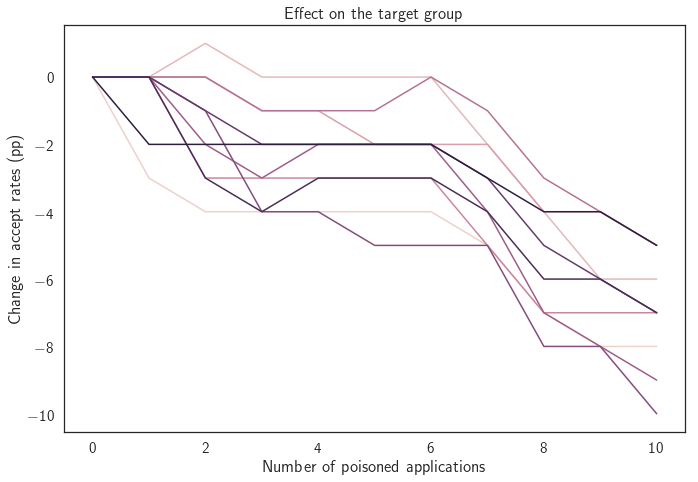

In [29]:
fig, ax = plt.subplots()

sns.lineplot(data=noisy_scores_50_df.query("Group == 'Target'"),
             x='poison_size', y='fp_change', hue='sim', ci=None, legend=False,
             err_style='bars', ax=ax)
# sns.lineplot(data=noisy_scores_10_df.query("Group == 'Target'"),
#              x='poison_size', y='fn_change', hue='sim', ci=None, legend=False,
#              err_style='bars', ax=ax, palette="BuGn_r")

ax.set_ylabel("Change in accept rates (pp)")
ax.set_xlabel("Number of poisoned applications")
ax.set_title('Effect on the target group')

fig.set_figwidth(10)
fig.set_figheight(7)
fig.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, 'poisoning_trajectories.pdf'))

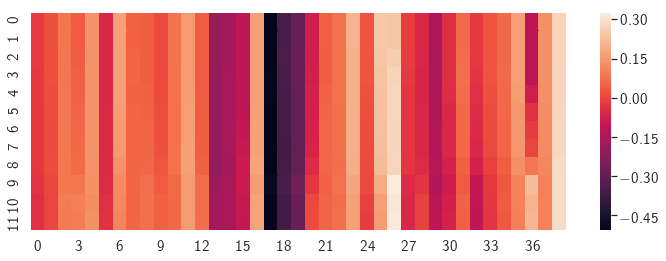

In [30]:
coef_mat = np.zeros([len(base_models[0]) + 1, X.shape[1] + 1])
for i, clf_adv in enumerate([clf] + base_models[0]):
    coef_vec = np.concatenate([clf_adv.coef_[0, :], [clf_adv.intercept_[0]]])
    coef_vec /= np.linalg.norm(coef_vec)
    coef_mat[i, :] = coef_vec
    
fig, ax = plt.subplots()
sns.heatmap(coef_mat, ax=ax)

fig.set_figwidth(12)